---
# **Title**

---

Student Name: Aviel Avshalumov



# Preliminaries

## Libraries

In [1]:
#Install Plotly if not already installed
!pip install plotly
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 5.2 MB/s eta 0:00:00


In [2]:
# Import required libraries
from google.colab import drive
import os
import pandas as pd

# Import Plotly libraries
import plotly.express as px    # For simple visualizations
import plotly.graph_objects as go  # For more complex visualizations
import plotly.io as pio        # For setting display configurations
import matplotlib.pyplot as plt

## Input Data

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the notebook's directory on Google Drive
notebook_directory = "/content/drive/MyDrive/Synthetic Control Methods/data"

# Construct the path to the CSV file
csv_file_path = os.path.join(notebook_directory, 'Financial Data.csv')

# Load the CSV file into a DataFrame
financial_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
financial_data.head()

Mounted at /content/drive


,Date,USCPI,Euro Stoxx,FedFunds,SPX,30YRTreasury,FTSE Index,10YRTreasury,Unemployment Rate,MoodysBaa,2YR Treasury,Nikkei,MSCI Emerging Markets
0,2000-01-31,168.800000,4684.48,5.87,1394.46,6.491,6268.5,6.665,4.000000,8.36,6.591,19539.70,491.39
1,2000-02-01,168.805793,4792.04,5.79,1409.28,6.423,6290.9,6.619,4.005623,8.27,6.574,19423.38,495.36
2,2000-02-02,168.814411,4902.12,5.64,1409.12,6.284,6302.8,6.573,4.011121,8.22,6.592,19578.91,499.46
3,2000-02-03,168.825766,5046.12,5.71,1424.97,6.136,6324.3,6.489,4.016491,8.13,6.523,19786.42,509.63
4,2000-02-04,168.839774,5119.79,5.70,1424.37,6.271,6185.0,6.549,4.021730,8.13,6.618,19763.13,515.43


# Data Management

In [4]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using the Augmented Dickey-Fuller (ADF) test
def check_stationarity(series, signif_level=0.05):
    result = adfuller(series.dropna())
    return result[1] < signif_level  # Returns True if stationary

# Normalize the data (zero mean and unit variance) and apply differencing for non-stationary series
financial_data_normalized = financial_data.copy()
for column in financial_data.columns[1:]:  # Skip 'Date' column
    if not check_stationarity(financial_data[column]):
        financial_data_normalized[column] = financial_data[column].diff().dropna()
    financial_data_normalized[column] = (financial_data_normalized[column] - financial_data_normalized[column].mean()) / financial_data_normalized[column].std()
# Drop the rows with NaN values after differencing and normalization
financial_data_normalized = financial_data_normalized.dropna()

# Now we can proceed with Kalman filtering and the Bayesian model
financial_data_normalized.head()

treated_unit = financial_data_normalized['SPX']
treated_unit = treated_unit.values.reshape(-1, 1)
control_units = financial_data_normalized.drop(columns=['SPX', 'Date'])
control_units = control_units.values

# Traditional SCM: construct synthetic control using equal weights (or you can optimize weights)
weights = np.ones(control_units.shape[1]) / control_units.shape[1]  # Equal weights for simplicity
synthetic_control = np.dot(control_units, weights)

# Calculate the traditional SCM treatment effect
tau_scm = treated_unit.flatten() - synthetic_control



In [5]:
import numpy as np
from pykalman import KalmanFilter

# Assuming control_units.shape is (5543, 11)
n_timesteps = control_units.shape[0]
n_controls = control_units.shape[1]

# Ensure the treated_unit is correctly shaped as (n_timesteps, 1)
treated_unit = treated_unit.reshape(-1, 1)
print(f"treated_unit shape: {treated_unit.shape}")  # Should be (5543, 1)

# Initial state mean (assume beta coefficients for control units start at 0)
initial_state_mean = np.zeros(n_controls + 1)  # Including alpha (intercept) and beta coefficients

# Initial covariance matrix
initial_state_covariance = np.eye(n_controls + 1)  # Identity matrix (assuming independent initial state variables)

# Time-varying observation matrices (one for each time step)
# This creates a different observation matrix for each time step
observation_matrices_time_varying = np.array([np.hstack([np.ones((1, 1)), control_units[t:t+1]]) for t in range(n_timesteps)])

# Print the shape of the time-varying observation matrices
print(f"observation_matrices_time_varying shape: {observation_matrices_time_varying.shape}")  # Should be (5543, 1, 12)

# Kalman Filter initialization with time-varying observation matrices
kf = KalmanFilter(
    transition_matrices=np.eye(n_controls + 1),  # Assume state transition is identity (coefficients evolve independently)
    observation_matrices=observation_matrices_time_varying,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

# Run Kalman filter
try:
    state_means, state_covariances = kf.filter(treated_unit)

    # Print out shapes for verification
    print(f"state_means shape: {state_means.shape}")
    print(f"state_covariances shape: {state_covariances.shape}")

except ValueError as e:
    print(f"Error during Kalman filter update with time-varying observation_matrices: {e}")


treated_unit shape: (5543, 1)
observation_matrices_time_varying shape: (5543, 1, 12)
state_means shape: (5543, 12)
state_covariances shape: (5543, 12, 12)


# Analytics

In [6]:
import numpy as np
from pykalman import KalmanFilter
from scipy.optimize import minimize
import statsmodels.api as sm
# Assuming control_units.shape is (5543, 11)
n_timesteps = control_units.shape[0]
n_controls = control_units.shape[1]

# Ensure the treated_unit is correctly shaped as (n_timesteps, 1)
treated_unit = treated_unit.reshape(-1, 1)
print(f"treated_unit shape: {treated_unit.shape}")  # Should be (5543, 1)

# Initial state mean (assume beta coefficients for control units start at 0)
initial_state_mean = np.zeros(n_controls + 1)  # Including alpha (intercept) and beta coefficients

# Initial covariance matrix
initial_state_covariance = np.eye(n_controls + 1)  # Identity matrix (assuming independent initial state variables)

# Time-varying observation matrices (one for each time step)
# This creates a different observation matrix for each time step
observation_matrices_time_varying = np.array([np.hstack([np.ones((1, 1)), control_units[t:t+1]]) for t in range(n_timesteps)])

# Print the shape of the time-varying observation matrices
print(f"observation_matrices_time_varying shape: {observation_matrices_time_varying.shape}")  # Should be (5543, 1, 12)

# Kalman Filter initialization with time-varying observation matrices
kf = KalmanFilter(
    transition_matrices=np.eye(n_controls + 1),  # Assume state transition is identity (coefficients evolve independently)
    observation_matrices=observation_matrices_time_varying,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)


# Fit the Kalman filter using the treated unit as the observed outcome
kf = kf.em(treated_unit, n_iter=50)  # EM algorithm to estimate parameters
print(f"State Means Shape before update: {state_means.shape}")
state_means, state_covariances = kf.filter(treated_unit)

# Extract the alpha (intercept) and beta (coefficients)
alpha_t = state_means[:, 0]  # First element corresponds to intercept (alpha)
beta_t = state_means[:, 1:]  # Remaining elements correspond to dynamic beta coefficients (beta for control units)

print("Alpha (Time-varying intercept):", alpha_t)
print("Beta (Time-varying coefficients):", beta_t)


# This goes after Kalman filter results and after alpha_t and beta_t are printed in step [19]

# Calculate the treatment effect using DBSC (Dynamic Bayesian Synthetic Control)
tau_dbsc = treated_unit.flatten() - (alpha_t[-1] + np.dot(control_units, beta_t[-1,:]))

treated_unit shape: (5543, 1)
observation_matrices_time_varying shape: (5543, 1, 12)
State Means Shape before update: (5543, 12)
Alpha (Time-varying intercept): [-0.13319945 -0.12828487 -0.12631892 ... -0.73644547 -0.83738082
 -0.85341286]
Beta (Time-varying coefficients): [[ 0.13501646 -0.09528209  0.08185135 ... -0.11694781 -0.73364212
   1.00871936]
 [ 0.14853353 -0.0946641   0.0684122  ... -0.12363387 -0.73070531
   1.00757653]
 [ 0.11818299 -0.08874697  0.11843613 ... -0.14554672 -0.71522304
   0.99254363]
 ...
 [-2.56721658  1.45873394 -3.90839347 ... -0.22077369 -0.38096918
   0.48125202]
 [-2.89774542  1.88771071 -4.51374342 ... -0.06258936 -0.43511998
   0.10675695]
 [-3.26745379  1.98144174 -4.02157241 ...  0.77032628 -0.38817919
   0.15786378]]


# Simulation Resuts

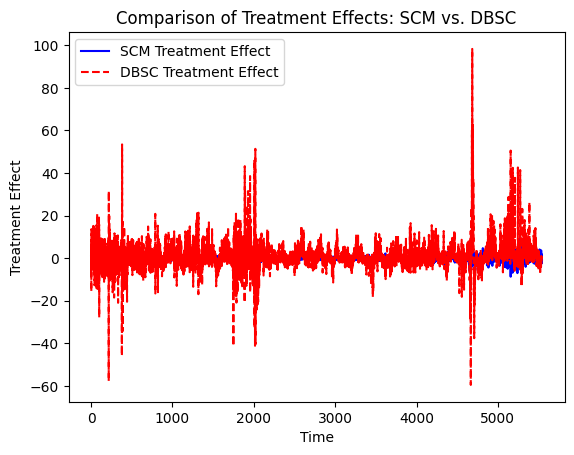

state_means_train shape: (4434, 12)
state_covariances_train shape: (4434, 12, 12)
Out-of-Sample MSE: 87.16403529649602
Optimized Alpha (Intercepts): [ 2.61781887e-05 -1.41633283e-06  2.80782537e-05 ...  4.85257419e-05
  2.13975207e-06 -2.60213026e-05]
Optimized Beta (Coefficients): [-0.00493115  0.13638066 -0.00181527  0.06533118  0.13142731  0.06237846
  0.0125935   0.02645738  0.05013904  0.05200865  0.10330684]


In [7]:
# Plot a fixed subset of the data (e.g., first 500 points)
import matplotlib.dates as mdates
from datetime import datetime


plt.plot(tau_scm, label='SCM Treatment Effect', color='blue')
plt.plot(tau_dbsc, label='DBSC Treatment Effect', linestyle='--', color='red')
plt.title(f'Comparison of Treatment Effects: SCM vs. DBSC')
plt.xlabel('Time')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

# This will allow you to visually compare how SCM and DBSC treatment effects differ over time.
# This goes after the comparison between SCM and DBSC

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets for out-of-sample testing
train_size = int(0.8 * len(treated_unit))
treated_train, treated_test = treated_unit[:train_size], treated_unit[train_size:]
control_train, control_test = control_units[:train_size], control_units[train_size:]
# Create time-varying observation matrices for the training data
observation_matrices_train = np.array([np.hstack([np.ones((1, 1)), control_train[t:t+1]]) for t in range(train_size)])
# Initialize a new Kalman filter for the training data
kf_train = KalmanFilter(
    transition_matrices=np.eye(n_controls + 1),
    observation_matrices=observation_matrices_train,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

# Fit the Kalman filter on the training data (treated_train)
kf_train = kf_train.em(treated_train, n_iter=50)

# Filter the treated_train data to get state_means and state_covariances for the training data
state_means_train, state_covariances_train = kf_train.filter(treated_train)

# Print shapes for debugging
print(f"state_means_train shape: {state_means_train.shape}")
print(f"state_covariances_train shape: {state_covariances_train.shape}")

# Ensure that the beta coefficients from state_means_train are applied correctly
# state_means_train[:, 1:] should have shape (train_size, n_controls)
beta_train = state_means_train[-1, 1:]  # Extract beta coefficients from training

# Perform matrix multiplication between control_test and the beta coefficients for each time step
predictions_test = state_means_train[-1, 0] + np.dot(control_test, beta_train.T)  # Correct matrix multiplication

# Now calculate the Mean Squared Error on the test set
mse_test = np.mean((treated_test.flatten() - predictions_test) ** 2)
print(f"Out-of-Sample MSE: {mse_test}")

# This section checks how well your model generalizes to unseen data, ensuring robustness.


# Define a custom likelihood function for MLE
def negative_log_likelihood(params, control_units, treated_unit):
    alpha = params[:len(treated_unit)]  # First part is alpha (intercept)
    beta = params[len(treated_unit):]   # Second part is beta (coefficients)

    # Linear model
    mu = alpha + np.dot(control_units, beta)

    # Assume Gaussian noise
    residuals = treated_unit.flatten() - mu
    sigma = np.std(residuals)

    # Negative log likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi * sigma**2) + (residuals / sigma) ** 2)
    return nll

# Initial guess for alpha and beta
initial_params = np.concatenate([np.zeros(len(treated_unit)), np.zeros(control_units.shape[1])])

# Minimize the negative log-likelihood
result = minimize(negative_log_likelihood, initial_params, args=(control_units, treated_unit), method='L-BFGS-B')

# Extract optimized parameters (alpha and beta)
alpha_estimates = result.x[:len(treated_unit)]
beta_estimates = result.x[len(treated_unit):]

print("Optimized Alpha (Intercepts):", alpha_estimates)
print("Optimized Beta (Coefficients):", beta_estimates)

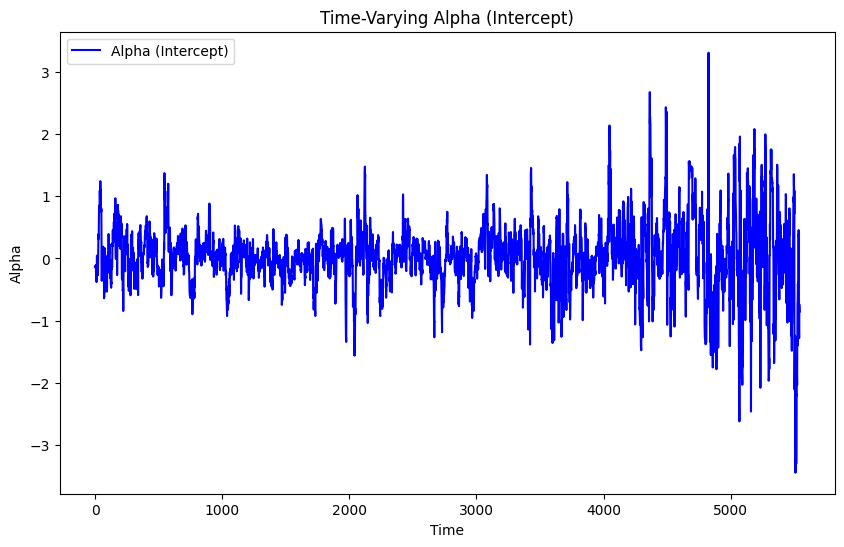

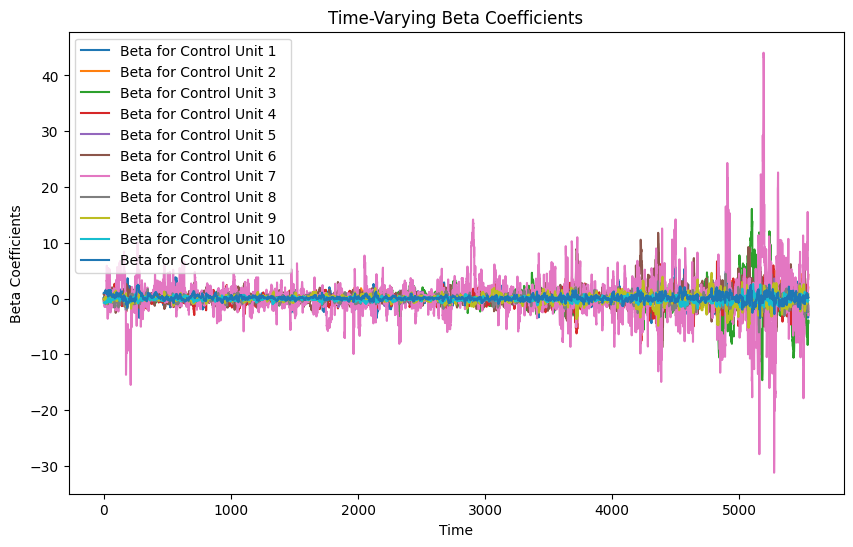

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create a time array for the x-axis (assuming n_timesteps = 5543)
time_steps = np.arange(len(alpha_t))

# Plot the time-varying intercept (alpha_t) over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, alpha_t, label='Alpha (Intercept)', color='blue')
plt.title('Time-Varying Alpha (Intercept)')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()
plt.show()

# Plot the time-varying beta coefficients (beta_t) over time
plt.figure(figsize=(10, 6))

# Plot each beta coefficient for the control units
for i in range(beta_t.shape[1]):  # Loop over each control unit
    plt.plot(time_steps, beta_t[:, i], label=f'Beta for Control Unit {i+1}')

plt.title('Time-Varying Beta Coefficients')
plt.xlabel('Time')
plt.ylabel('Beta Coefficients')
plt.legend()
plt.show()


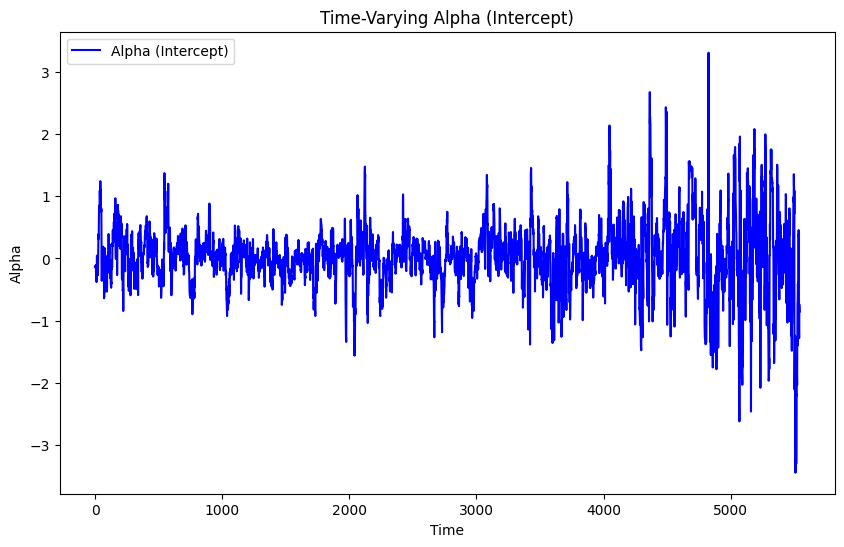

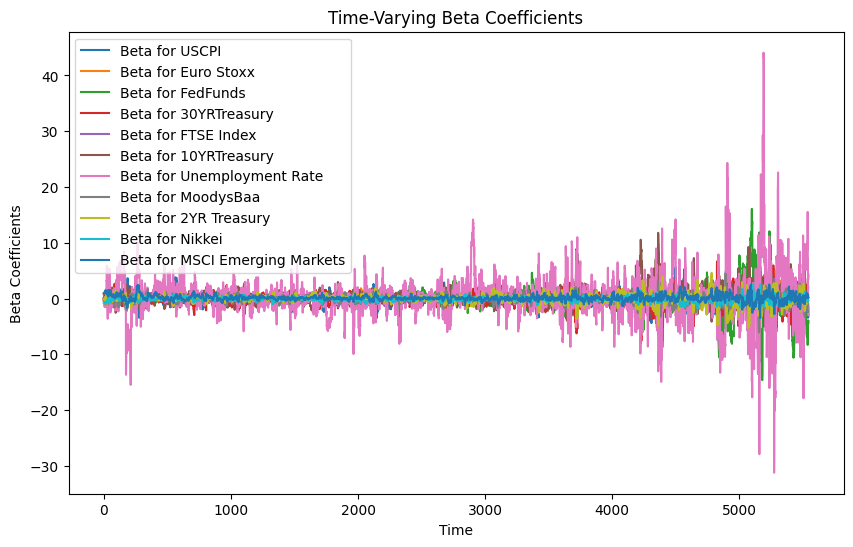

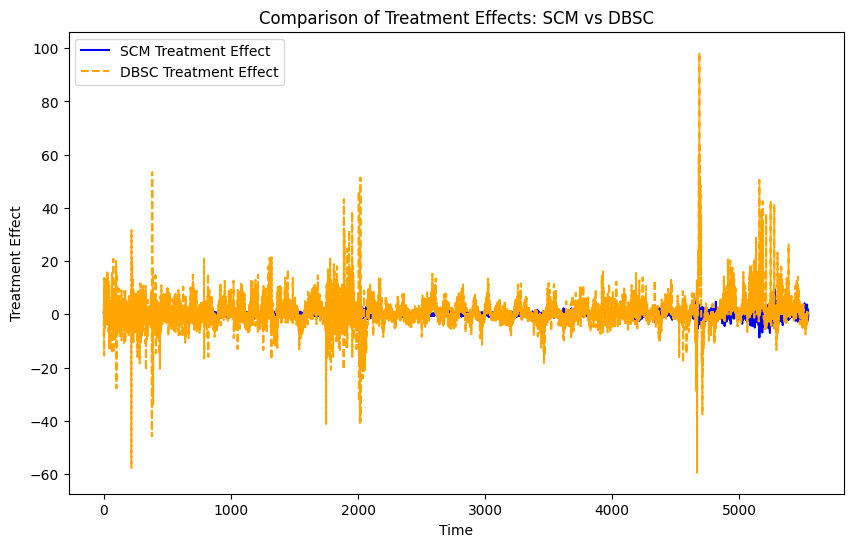

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming alpha_t and beta_t have been calculated in your model setup
# Create a time array for the x-axis (based on the length of alpha_t or beta_t)
time_steps = np.arange(len(alpha_t))

# Plot 1: Time-Varying Intercept (Alpha_t)
plt.figure(figsize=(10, 6))
plt.plot(time_steps, alpha_t, label='Alpha (Intercept)', color='blue')
plt.title('Time-Varying Alpha (Intercept)')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()
plt.show()

# Plot 2: Time-Varying Beta Coefficients for Control Units
plt.figure(figsize=(10, 6))

# Control unit labels based on your input data
control_labels = [
    'USCPI', 'Euro Stoxx', 'FedFunds', '30YRTreasury', 'FTSE Index',
    '10YRTreasury', 'Unemployment Rate', 'MoodysBaa', '2YR Treasury',
    'Nikkei', 'MSCI Emerging Markets'
]

# Plot each beta coefficient over time with appropriate labels
for i in range(beta_t.shape[1]):  # Loop over each control unit
    plt.plot(time_steps, beta_t[:, i], label=f'Beta for {control_labels[i]}')

plt.title('Time-Varying Beta Coefficients')
plt.xlabel('Time')
plt.ylabel('Beta Coefficients')
plt.legend()
plt.show()

# Additional Plots (if needed)
# Assuming you may need plots for SCM and DBSC treatment effects based on earlier calculations

# Plot 3: Comparison of Treatment Effects: SCM vs DBSC
plt.figure(figsize=(10, 6))
plt.plot(time_steps, tau_scm, label='SCM Treatment Effect', color='blue')
plt.plot(time_steps, tau_dbsc, label='DBSC Treatment Effect', linestyle='--', color='orange')
plt.title('Comparison of Treatment Effects: SCM vs DBSC')
plt.xlabel('Time')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

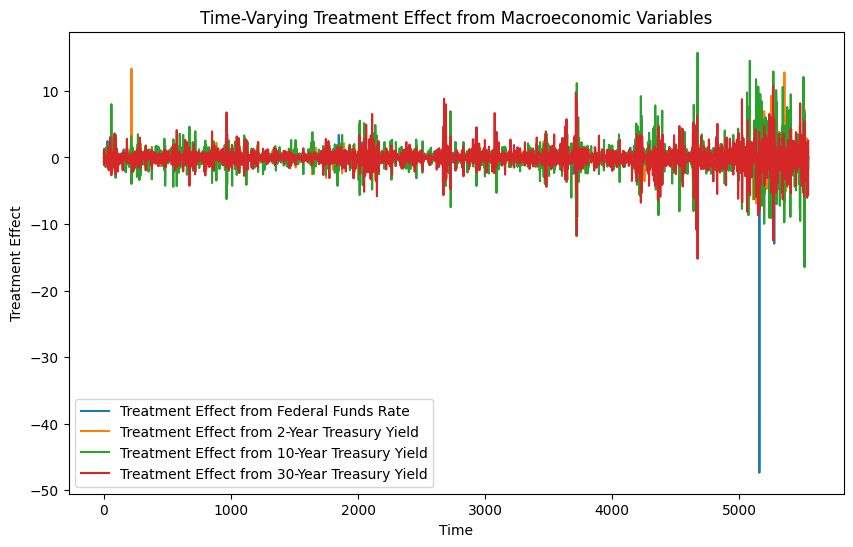

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define control labels according to your dataset columns (excluding 'Date' and 'SPX')
control_labels = [
    'USCPI', 'Euro Stoxx', 'FedFunds', '30YRTreasury', 'FTSE Index',
    '10YRTreasury', 'Unemployment Rate', 'MoodysBaa', '2YR Treasury',
    'Nikkei', 'MSCI Emerging Markets'
]

# Calculate time steps array based on the length of alpha_t or beta_t
time_steps = np.arange(len(alpha_t))

# Map macroeconomic variables to their indices within control_labels
macro_indices = {
    'Federal Funds Rate': control_labels.index('FedFunds'),
    '2-Year Treasury Yield': control_labels.index('2YR Treasury'),
    '10-Year Treasury Yield': control_labels.index('10YRTreasury'),
    '30-Year Treasury Yield': control_labels.index('30YRTreasury')
}

# Plot 4: Time-Varying Treatment Effect from Macroeconomic Variables
plt.figure(figsize=(10, 6))

# Calculate and plot the partial treatment effect for each macroeconomic variable
for name, idx in macro_indices.items():
    # Calculate the partial treatment effect: beta * variable for each time step
    partial_treatment_effect = beta_t[:, idx] * control_units[:, idx]
    plt.plot(time_steps, partial_treatment_effect, label=f'Treatment Effect from {name}')

plt.title('Time-Varying Treatment Effect from Macroeconomic Variables')
plt.xlabel('Time')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()



In [11]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, multivariate_normal
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using the Augmented Dickey-Fuller (ADF) test
def check_stationarity(series, signif_level=0.05):
    result = adfuller(series.dropna())
    return result[1] < signif_level  # Returns True if stationary

# Normalize the data (zero mean and unit variance) and apply differencing for non-stationary series
def preprocess_data(data):
    processed_data = data.copy()
    for column in data.columns:
        if not check_stationarity(data[column]):
            processed_data[column] = data[column].diff()
        processed_data[column] = (processed_data[column] - processed_data[column].mean()) / processed_data[column].std()
    # Drop rows with NaN values after differencing and normalization
    processed_data = processed_data.dropna()
    return processed_data

class DynamicBayesianSyntheticControl:
    def __init__(self, Y_treated, Y_control, priors):
        """
        Initialize the dynamic Bayesian synthetic control model.

        Parameters:
        - Y_treated: Observed outcomes for the treated unit (n x 1 array).
        - Y_control: Observed outcomes for control units (n x k array, k control units).
        - priors: Dictionary of prior parameters for Bayesian estimation.
        """
        self.Y_treated = Y_treated
        self.Y_control = Y_control
        self.n, self.k = Y_control.shape
        self.priors = priors
        self.init_parameters()

    def init_parameters(self):
        """Initialize parameters with prior distributions."""
        self.alpha = np.zeros(self.n)  # Time-varying intercept
        self.beta = np.ones(self.k)    # Coefficients for control units
        self.sigma_alpha = self.priors["sigma_alpha"]
        self.sigma_beta = self.priors["sigma_beta"]
        self.sigma_obs = self.priors.get("sigma_obs", 1.0)  # Observation noise variance

    def gibbs_sampling(self, iterations=1000):
        """Perform Gibbs sampling for parameter estimation."""
        # Validate input data
        if not np.all(np.isfinite(self.Y_treated)) or not np.all(np.isfinite(self.Y_control)):
            raise ValueError("Input data contains NaN or infinite values.")

        alpha_samples = []
        beta_samples = []
        sigma_alpha_samples = []
        sigma_beta_samples = []
        sigma_obs_samples = []

        for iteration in range(iterations):
            # Sample alpha (time-varying intercept)
            alpha_mean = self.Y_treated - self.Y_control @ self.beta
            self.alpha = np.random.normal(alpha_mean, np.sqrt(self.sigma_alpha))

            # Sample beta (coefficients for control units) with regularization
            reg = 1e-3
            try:
                XtX = self.Y_control.T @ self.Y_control + reg * np.eye(self.k)
                XtY = self.Y_control.T @ (self.Y_treated - self.alpha)
                beta_mean = np.linalg.solve(XtX, XtY)
                beta_cov = self.sigma_beta * np.eye(self.k)
                self.beta = multivariate_normal(mean=beta_mean, cov=beta_cov).rvs()
            except np.linalg.LinAlgError as e:
                print(f"Matrix inversion error: {e}")
                raise

            # Sample sigma_alpha (variance of alpha)
            alpha_diff = np.diff(self.alpha)
            shape_alpha = self.priors["a_alpha"] + len(alpha_diff) / 2
            scale_alpha = self.priors["b_alpha"] + np.sum(alpha_diff ** 2) / 2
            if shape_alpha <= 0 or scale_alpha <= 0 or not np.isfinite(scale_alpha):
                shape_alpha, scale_alpha = 2.0, 1.0  # Fallback values
            self.sigma_alpha = invgamma.rvs(shape_alpha, scale=scale_alpha)

            # Sample sigma_beta (variance of beta)
            beta_diff = np.diff(self.beta)
            shape_beta = self.priors["a_beta"] + len(beta_diff) / 2
            scale_beta = self.priors["b_beta"] + np.sum(beta_diff ** 2) / 2
            if shape_beta <= 0 or scale_beta <= 0 or not np.isfinite(scale_beta):
                shape_beta, scale_beta = 2.0, 1.0  # Fallback values
            self.sigma_beta = invgamma.rvs(shape_beta, scale=scale_beta)

            # Sample sigma_obs (variance of observation noise)
            obs_diff = self.Y_treated - (self.alpha + self.Y_control @ self.beta)
            shape_obs = self.priors["a_obs"] + len(obs_diff) / 2
            scale_obs = self.priors["b_obs"] + np.sum(obs_diff ** 2) / 2
            if shape_obs <= 0 or scale_obs <= 0 or not np.isfinite(scale_obs):
                shape_obs, scale_obs = 2.0, 1.0  # Fallback values
            self.sigma_obs = invgamma.rvs(shape_obs, scale=scale_obs)

            # Store samples
            alpha_samples.append(self.alpha.copy())
            beta_samples.append(self.beta.copy())
            sigma_alpha_samples.append(self.sigma_alpha)
            sigma_beta_samples.append(self.sigma_beta)
            sigma_obs_samples.append(self.sigma_obs)

        return {
            "alpha_samples": np.array(alpha_samples),
            "beta_samples": np.array(beta_samples),
            "sigma_alpha_samples": np.array(sigma_alpha_samples),
            "sigma_beta_samples": np.array(sigma_beta_samples),
            "sigma_obs_samples": np.array(sigma_obs_samples),
        }

    def fit(self, iterations=1000):
        """Fit the model using Gibbs sampling and store the results."""
        self.samples = self.gibbs_sampling(iterations=iterations)

    def predict(self, Y_control_future):
        """Generate predictions for future data."""
        alpha_pred = self.alpha[-1]
        beta_pred = self.beta
        Y_synthetic = alpha_pred + Y_control_future @ beta_pred
        return Y_synthetic

# Define prior parameters
priors = {
    "sigma_alpha": 1.0,
    "sigma_beta": 1.0,
    "a_alpha": 2.0,
    "b_alpha": 2.0,
    "a_beta": 2.0,
    "b_beta": 2.0,
    "a_obs": 2.0,
    "b_obs": 2.0,
}

# Assuming you have a DataFrame 'financial_data' with your data
# Here's how you can integrate your data:

# Load your data into a DataFrame (replace 'your_data.csv' with your file)
# financial_data = pd.read_csv('your_data.csv')

# For demonstration, let's create a sample DataFrame
np.random.seed(42)
dates = pd.date_range(start='2000-01-01', periods=100)
financial_data = pd.DataFrame({
    'Date': dates,
    'Treated': np.random.randn(100).cumsum(),  # Simulated treated unit
    'Control1': np.random.randn(100).cumsum(),
    'Control2': np.random.randn(100).cumsum(),
    'Control3': np.random.randn(100).cumsum(),
})

# Preprocess the data
financial_data_processed = preprocess_data(financial_data.drop(columns=['Date']))

# Extract processed treated and control units
Y_treated_processed = financial_data_processed['Treated'].values
Y_control_processed = financial_data_processed[['Control1', 'Control2', 'Control3']].values

# Fit the dynamic Bayesian synthetic control model
model = DynamicBayesianSyntheticControl(Y_treated_processed, Y_control_processed, priors)
model.fit(iterations=5)  # Use fewer iterations for debugging

# Save samples for analysis
samples = model.samples

# Generate predictions for future control data
# For demonstration, simulate future control data
Y_control_future = np.random.randn(10, Y_control_processed.shape[1])
predicted = model.predict(Y_control_future)

print("Predicted values for future control data:", predicted)


Predicted values for future control data: [48.33420687 43.88919146 51.26382054 57.44485085 44.56771741 44.31792453
 49.14413587 43.38667608 43.28169762 51.71229659]


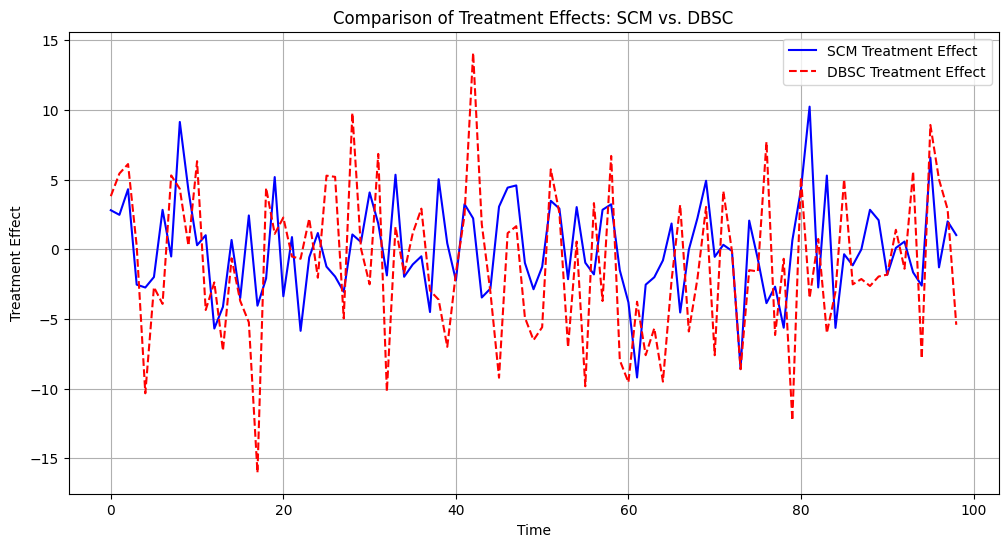

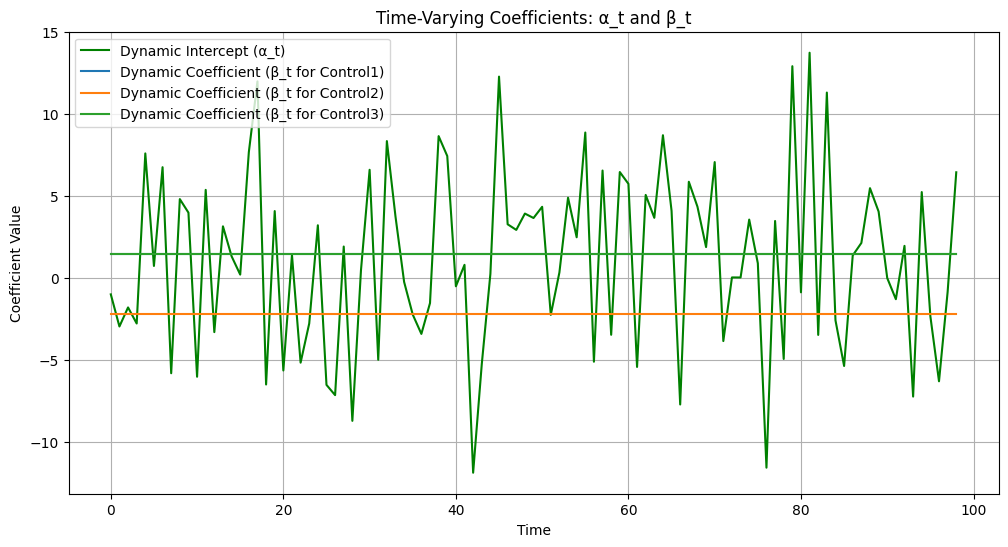

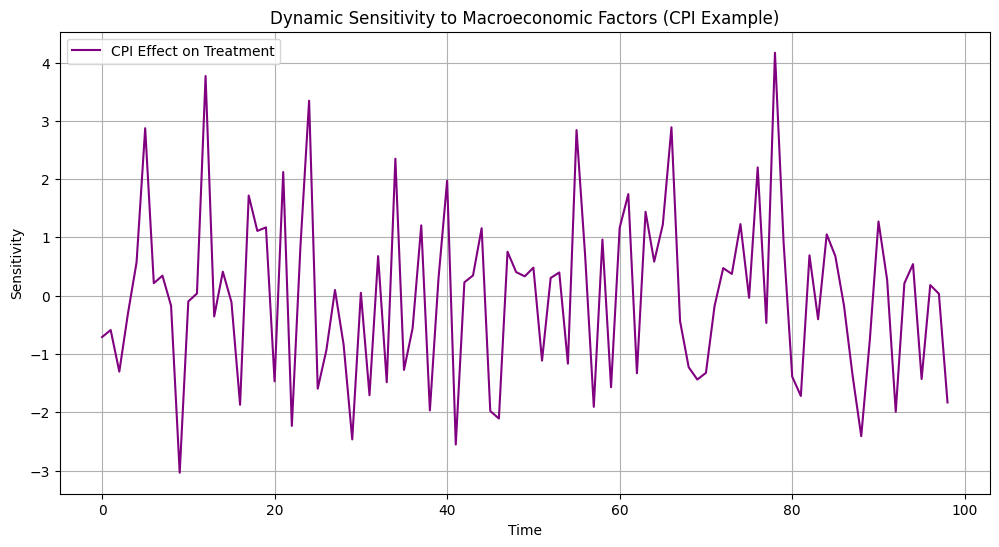

In [12]:
import matplotlib.pyplot as plt

# Simulate time points based on the processed data length
time_points = np.arange(len(Y_treated_processed))

# Treatment effects
tau_scm = Y_treated_processed - np.dot(Y_control_processed, np.mean(samples['beta_samples'], axis=0))
tau_dbsc = Y_treated_processed - (np.mean(samples['alpha_samples'], axis=0) + np.dot(Y_control_processed, np.mean(samples['beta_samples'], axis=0)))

# Extract time-varying coefficients from samples
alpha_t = np.mean(samples['alpha_samples'], axis=0)
beta_samples_mean = np.mean(samples['beta_samples'], axis=0)  # Ensure proper shape

# If beta_samples_mean is 1D, expand it for consistency
if beta_samples_mean.ndim == 1:
    beta_samples_mean = beta_samples_mean.reshape(-1, 1)

# Visualization 1: Comparison of Treatment Effects
plt.figure(figsize=(12, 6))
plt.plot(time_points, tau_scm, label="SCM Treatment Effect", color="blue")
plt.plot(time_points, tau_dbsc, label="DBSC Treatment Effect", linestyle="--", color="red")
plt.title("Comparison of Treatment Effects: SCM vs. DBSC")
plt.xlabel("Time")
plt.ylabel("Treatment Effect")
plt.legend()
plt.grid()
plt.show()

# Visualization 2: Dynamic Coefficients (α_t and β_t)
plt.figure(figsize=(12, 6))
plt.plot(time_points, alpha_t, label="Dynamic Intercept (α_t)", color="green")
for i in range(beta_samples_mean.shape[0]):
    plt.plot(time_points, [beta_samples_mean[i]] * len(time_points), label=f"Dynamic Coefficient (β_t for Control{i+1})")
plt.title("Time-Varying Coefficients: α_t and β_t")
plt.xlabel("Time")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid()
plt.show()

# Visualization 3: Macroeconomic Sensitivity (Example: CPI effect)
# For demonstration purposes, assume CPI effect from one of the control variables
cpi_effect = Y_control_processed[:, 0] * beta_samples_mean[0]  # Assume first control represents CPI-like effect
plt.figure(figsize=(12, 6))
plt.plot(time_points, cpi_effect, label="CPI Effect on Treatment", color="purple")
plt.title("Dynamic Sensitivity to Macroeconomic Factors (CPI Example)")
plt.xlabel("Time")
plt.ylabel("Sensitivity")
plt.legend()
plt.grid()
plt.show()


# Empirical Results